In [1]:
# ------------------------------------------------- #
#  
#  SUBMIT SCRIPT TO QUANTUM COMPUTE TOPOLOGICAL ORDER PARAMETER
#  Niklas Mueller, Joseph A. Carolan, Andrew Connelly, Zohreh Davoudi, Eugene F. Dumitrescu, Kübra Yeter-Aydeniz
#  arXiv:2210.03089
#
# Copyright 2023 Niklas Mueller, Joseph A. Carolan, Andrew Connelly, Zohreh Davoudi, Eugene F. Dumitrescu, Kübra Yeter-Aydeniz
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), 
# to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, 
# and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
# 
# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
# 
# THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, 
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER 
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS 
# IN THE SOFTWARE.
# 
# ------------------------------------------------- #

import sys
import os, csv
import numpy as np
np.set_printoptions(precision=4)
import pickle
import matplotlib.ticker as ticker
import math
import scipy
from scipy.stats import unitary_group
from qiskit import *
from qiskit.result import marginal_counts
from qiskit.providers.ibmq.job import job_monitor
from qiskit.tools.visualization import plot_histogram
from qiskit import transpile
import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram
%matplotlib inline

import INCLUDE.basic
import INCLUDE
from INCLUDE.basis_transformations import Bogoliubov_staggered_mom_to_particle_antiparticle
from INCLUDE.basis_transformations import SFFFT_mom_to_pos
from INCLUDE.basis_transformations import quench_gate
from INCLUDE.physics import dispersion
from INCLUDE.interactions import compute_couplings
from INCLUDE.interactions import interaction_part_controlled
from INCLUDE.interactions import interaction_part

# use this for AER simulator
from qiskit.providers.aer import QasmSimulator
# use this for IONQ simulator and devices
# from qiskit_ionq import IonQProvider
# use this for IONQ simulator and devices via Microsoft Azure
# from azure.quantum.qiskit import AzureQuantumProvider


In [2]:
# ------------------------------------------------- #
#  Parameters
# ------------------------------------------------- #
N = 4            # lattice sites
m = 0.9          # mass
n_shots = 500    # shots
T = 0.8           # time evolution to T
RunName = "your_run_name" # optional give a custom run name
q = -1            # mode in momentum space, must run from -N//4 to N//4-1 

# ------------------------------------------------- #
#  Circuit options
# ------------------------------------------------- #
RUN_RandI = 'Y'      # compute real and imaginary part in one circuit (Y/N)
NO_CONTROL = 'Y'     # avoid controls on phase evolution of time evolution (Y/N), they are not strictly needed
                     # because controll or operator insertions between forward and backward evolution is sufficient

# ------------------------------------------------- #
#  BACKEND
# ------------------------------------------------- #
run_backend = 'AER'       # backend

# ------------------------------------------------- #
#  PROVIDER
# ------------------------------------------------- #
my_provider='NONE'       # choose AZURE or GCP or NONE, not needed if running on AER simulator

In [3]:
# -------------------------------------------------- #
#  AER SIMULATOR 
# -------------------------------------------------- #
if run_backend=='AER':
    my_backend = BasicAer.get_backend('qasm_simulator')
    
# -------------------------------------------------- #
#  OTHER PROVIDERS
# -------------------------------------------------- #
# elif run_backend=='XXX':
#     if my_provider == 'YYY':
        # insert your provider here
            
print("# this job will run on",my_backend)

# this job will run on qasm_simulator


In [4]:
# ------------------------------------------------------------------------------ #
#  DATA OUTPUT
# ------------------------------------------------------------------------------ #
folder_save='output_folder_topo_q-'+str(q)+'_T-'+str(T)

if not os.path.exists(folder_save):
    os.makedirs(folder_save)
    
print("# writing to folder",folder_save)

# writing to folder output_folder_topo_q--1_T-0.8


In [5]:
# ----------------------------------------------------------------------------- #
# Definition of the operator inside of the non-equal time correlator
# e(iH(-m)t) \psi^\dagger e(-iHt) psi in (-m) eigenbasis 
# Definition of the operator inside of the non-equal time correlator
# FREE CASE, i.e. 2+1 qubits used for very q
# -------------------------------------------------------------------------------------------- #
def correlator_gate_free(my_q, my_N, my_m, s, dt, dagger = False):
    qcirc = qiskit.QuantumCircuit(2+1,name="Cfreeq_"+str(q))
    # NOTE: Jordan Wigner transformation, 
    # this circuit must run over all (2) 
    # qubits because of the JW transformation for the
    # fermion creation and annihilation operators.
    
    # First Operator --------------------------------------------------------------------- #
    # particle case -------------- #
    # no JW string for particle case, since this is the first site
    if s[0]=="+":
        if s[2]=="x":
            qcirc.cx(0,1)
        elif s[2]=="y":
            qcirc.cy(0,1)
        else: 
            sys.exit("Error must specify s[2]: x or y")
        
    # anti-particle case -------------- # 
    elif s[0]=="-":
        if s[2]=="x":
            qcirc.cx(0,2) # x operator on qubit 2
        elif s[2]=="y":
            qcirc.cy(0,2)
        else: 
            sys.exit("Error must specify s[2]: x or y")
            
        # JW string, only over first qubit (since there are two in total)
        qcirc.cz(0,1)
    else:
        sys.exit("Error must specify s[0]: + or -")
    # END First Operator ---------------------------------------------------------------- #

    # forward time evolution (uses exp( i z /2 ) gate) ---------------------------------- #
    w_q = dispersion(my_q, my_N, np.abs(my_m))
    if NO_CONTROL=='N':
        qcirc.crz(w_q * dt, 0, 1)
        qcirc.crz(w_q * dt, 0, 2)
    elif NO_CONTROL=='Y':
        qcirc.rz(w_q * dt, 1)
        qcirc.rz(w_q * dt, 2)
    
    # Second Operator --------------------------------------------------------------------- #
    # particle case -------------- #
    # no JW string because this is the first qubit
    if s[0]=="+":    
        if s[1]=="x":
            qcirc.cx(0,1)
        elif s[1]=="y":
            qcirc.cy(0,1)
        else: 
            sys.exit("Error must specify s[1]: x or y")
        
    # anti-particle case -------------- #   
    elif s[0]=="-":
        if s[1]=="x":
            qcirc.cx(0,2) # x operator on qubit 2
        elif s[1]=="y":
            qcirc.cy(0,2)
        else: 
            sys.exit("Error must specify s[1]: x or y")
            
        # JW string
        qcirc.cz(0,1)  
    else:
        sys.exit("Error must specify s[0]: + or -")
    # END Second Operator ---------------------------------------------------------------- #
        
    # backward time evolution ------------------------------------------------------------ #
    w_q = dispersion(my_q, my_N, np.abs(my_m))
    if NO_CONTROL=='N':
        qcirc.crz(w_q * (-dt), 0, 1)
        qcirc.crz(w_q * (-dt), 0, 2)
    elif NO_CONTROL=='Y':
        qcirc.rz(w_q * (-dt),  1)
        qcirc.rz(w_q * (-dt),  2)
    # END backward time evolution ------------------------------------------------------------ #
        
    if dagger==True:
        return qcirc.inverse()
    return qcirc
# END correlator_gate_free----------------------------------------------------------------- #



# PREFACTORS NEEDED FOR COMPUTATION OF CORRELATOR --------------------------------------- #
def correlator_pref(N, m, s, dagger = False):
    pref=1.0 + 0.0j
    
    # note there is no prefactor from the JW string because (-1)^2 = 1
    
    # particle case -------------- #
    if s[0]=="+":
        if s[2]=="x":
            pref *= 1.0
        elif s[2]=="y":
            pref *= -1.0j
        else: 
            sys.exit("Error must specify s[2]: x or y")

        if s[1]=="x":
            pref *= 1.0
        elif s[1]=="y":
            pref *= 1.0j
        else: 
            sys.exit("Error must specify s[1]: x or y")
        
    # anti-particle case -------------- # 
    elif s[0]=="-":
        if s[2]=="x":
            pref *= 1.0
        elif s[2]=="y":
            pref *= 1.0j
        else: 
            sys.exit("Error must specify s[2]: x or y")
        
        if s[1]=="x":
            pref *= 1.0
        elif s[1]=="y":
            pref *= -1.0j
           # pref *= 1.0j
        else:
            sys.exit("Error must specify s[1]: x or y")
    else:
        sys.exit("Error must specify s[0]: + or -")
    
    return pref

In [1]:
# -------------------------------------------------------------------- #
# computes real and imaginary part of L_q(t) (free evolution)
# note computed locally in q, so only uses 2+1 qubits
# NOTE: n_shots is the number of shots per component
# There are 8 components with real and imaginary part 
# MUST multiply x16 to get total number of shots for observable
# -------------------------------------------------------------------- #
def prep_Lqt_free(my_q,my_N,my_m,my_t,my_component):
    
    if my_component not in ["R" ,"I"]:
        sys.exit("# Error, gave component"+str(my_component)+", must be R or I")

    # correlator L_q(t) will be stored here
    lqt=0.0
    
    # unitary components of correlators
    s_list = ["+xx","+xy","+yx","+yy","-xx","-xy","-yx","-yy"]

    circ_list = []
    pref_list = []
    
    # simulator only: get reduced DM for cross check
    if run_backend=='ISIM' or run_backend=='AER':
        RDM_list = []
        RDM_B_list = []
        DM_list = []

    # loop over unitary components that make up operator
    for s in s_list:  
        my_sum=0.0

        circ = QuantumCircuit(3,3)
        qubits = [i for i in range(3)]
       
        circ.h(0)

        # Prepare energy eigenstates, all states 
        circ.x(1)
        circ.x(2)
        
        # Quench (not controlled)
        # quench (m --> -m) ----------------------------------- #
        circ.append(INCLUDE.basis_transformations.local_quench_gate(my_q, my_N, np.abs(m)),[1,2])
        # END quench ------------------------------------------ #

        # insert what operator to compute ------------------------------------ #  
        # local 2+1 qubit version, needs to be replaced by "general" in interacting case
        circ.append(correlator_gate_free(my_q, my_N, my_m, s, my_t),qubits)
        # END insert what operator to compute ------------------------------------ #
        
        # Prefactor is independent of Real / Imaginary part choice
        pref = correlator_pref( my_N, my_m, s)

        # measure Real or Imaginary part of correlator --------------------------- #
        # measure ancilla qubit
        # want to measure sigma^x, not sigma^z, thus must go to 
        # x-basis through Hadamard transform ie. X = HZH
        # apply S_dagger to imaginary circuit ancilla
        if my_component=="I":
            circ.sdg(0) 
        
        # Hadamard both ancillae for ramsey interferometry
        circ.h(0)
        
        # simulator only: get reduced DM for cross check ----------- #
        if run_backend=='ISIM' or run_backend=='AER':
        
            systemA =[0]      # density matrix of the ancilla
            systemB = [1,2]   # density matrix of the system
            rho_AB = qi.DensityMatrix.from_instruction(circ)
            rho_A = qi.partial_trace(rho_AB,systemB) 
            rho_B = qi.partial_trace(rho_AB,systemA) 
            myRDM=rho_A.to_operator().data
            myRDM_B=rho_B.to_operator().data
            myDM=rho_AB.to_operator().data
            RDM_list.append(myRDM)
            DM_list.append(myDM)
            RDM_B_list.append(myRDM_B)
        # --------------------------------------------------------- #
        
        # measure all quibts, 0 has the signal, 1 and 2 are for error mitigation
        for j in range(3):
            circ.measure(j,j)
        
        # Append circuit to the list of circuits that must be run
        circ_list.append(circ)
        pref_list.append(pref)
           
    # END loop over list of poerators to measure
    
    # simulator only
    if run_backend=='ISIM' or run_backend=='AER': 
        return circ_list, pref_list, s_list, RDM_list, DM_list, RDM_B_list 
    # when running on hardware
    else:
        return circ_list, pref_list, s_list 
 

In [7]:
# -------------------------------------------------------------------- #
# computes real and imaginary part of L_q(t) (free evolution)
# note computed locally in q, so only uses 2+1 qubits
# NOTE: n_shots is the number of shots per component
# There are 8 components with real and imaginary part 
# MUST multiply x16 to get total number of shots for observable
# REAL AND IMAGINARY PARTS COMPUTED IN ONE CIRCUIT
# -------------------------------------------------------------------- #

def prep_Lqt_free_RandI(my_q,my_N,my_m,my_t):

    # correlator L_q(t) will be stored here
    lqt=0.0
    
    # unitary components of correlators
    s_list = ["+xx","+xy","+yx","+yy","-xx","-xy","-yx","-yy"]

    circ_list = []
    pref_list = []
    
    # simulator only: get reduced DM for cross check
    if run_backend=='ISIM' or run_backend=='AER':
        RDM_list = []
        RDM_B_list = []
        DM_list = []

        RDM_list_R = []
        RDM_B_list_R = []
        DM_list_R = []

        RDM_list_I = []
        RDM_B_list_I = []
        DM_list_I = []

    
    # loop over unitary components that make up operator
    for s in s_list:  
        my_sum=0.0

        circ = QuantumCircuit(6,6)
        qubitsR = [i for i in range(3)]
        qubitsI = [i for i in range(3,6)]
        
        # initialize both ancilla qubits
        circ.h(0)
        circ.h(3)

        # Prepare energy eigenstates, R and I components
        # convention here is such that spin down state | \downarrow > (logical | 1 >)
        # is a particle number zero state.
        circ.x(1)
        circ.x(2)
        
        circ.x(4)
        circ.x(5)
        
        # Quench (not controlled)
        # quench (m --> -m) ----------------------------------- #
        circ.append(INCLUDE.basis_transformations.local_quench_gate(my_q, my_N, np.abs(m)),[1,2])
        circ.append(INCLUDE.basis_transformations.local_quench_gate(my_q, my_N, np.abs(m)),[4,5])
        # END quench ------------------------------------------ #

        # insert what operator to compute ------------------------------------ #  
        # local 2+1 qubit version, needs to be replaced by "general" in interacting case
        circ.append(correlator_gate_free(my_q, my_N, my_m, s, my_t),qubitsR)
        circ.append(correlator_gate_free(my_q, my_N, my_m, s, my_t),qubitsI)
        # END insert what operator to compute ------------------------------------ #
        
        # Prefactor is independent of Real / Imaginary part choice
        pref = correlator_pref( my_N, my_m, s)

        # measure Real or Imaginary part of correlator --------------------------- #
        # measure ancilla qubit
        # want to measure sigma^x, not sigma^z, thus must go to 
        # x-basis through Hadamard transform ie. X = HZH
        # Hadamard both ancillae for ramsey interferometry
        
        # real part
        circ.h(0)
        
        # imaginary part
        circ.sdg(3) 
        circ.h(3)
        
        # SIMULATOR ONLY --------------------------- #
        if run_backend=='ISIM' or run_backend=='AER':
        
            systemA =[0] # ancilla for R part
            systemB = [1,2,3,4,5]

            rho_AB = qi.DensityMatrix.from_instruction(circ)
            rho_A_R = qi.partial_trace(rho_AB,systemB) 
            rho_B_R = qi.partial_trace(rho_AB,systemA) 
            myRDM_R=rho_A_R.to_operator().data
            myRDM_B_R=rho_B_R.to_operator().data
            myDM_R=rho_AB.to_operator().data
            
            systemA =[4] # ancilla for I part
            systemB = [0,1,2,4,5]

            rho_A_I = qi.partial_trace(rho_AB,systemB) 
            rho_B_I = qi.partial_trace(rho_AB,systemA) 
            myRDM_I=rho_A_I.to_operator().data
            myRDM_B_I=rho_B_I.to_operator().data
            myDM_I=rho_AB.to_operator().data
            
            RDM_list_R.append(myRDM_R)
            DM_list_R.append(myDM_R)
            RDM_B_list_R.append(myRDM_B_R)
            RDM_list_I.append(myRDM_I)
            DM_list_I.append(myDM_I)
            RDM_B_list_I.append(myRDM_B_I)
        # ------------------------------------------ #
        
        # measure all qubits
        for j in range(6):
            circ.measure(j,j)
        
        # Append circuit to the list of circuits that must be run
        circ_list.append(circ)
        pref_list.append(pref)
        
    # END loop over list of operators to measure
    
    # simulator only
    if run_backend=='ISIM' or run_backend=='AER': 
        return circ_list, pref_list, s_list, RDM_list_R, DM_list_R, RDM_B_list_R , RDM_list_I, DM_list_I, RDM_B_list_I 
    # when running on hardware
    else:
        return circ_list, pref_list, s_list 

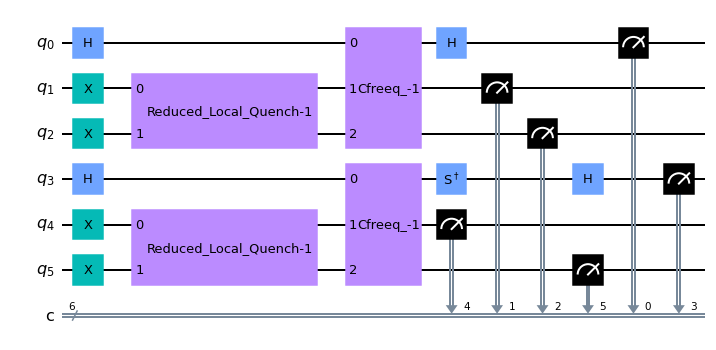

In [8]:
# ------------------------------------------------------------------------------ #
#  PREPARE CIRCUIT THAT WILL RUN
# ------------------------------------------------------------------------------ #

# if real and imaginary parts are separatel computed
if RUN_RandI=='N':
    # simulator
    if run_backend=='AER':
        quantum_circuits_R, pref_list_R, s_list_R, RDM_R, DM_R, RDM_B_R = prep_Lqt_free(q,N,m,T,"R")
        quantum_circuits_I, pref_list_I, s_list_I, RDM_I, DM_I, RDM_B_R = prep_Lqt_free(q,N,m,T,"I")
    # quantum device
   # elif run_backend=='XXXX':
        # insert transp. circuits for hardware
        
    test=quantum_circuits_R[0]
# if real and imaginary parts are computed in one circuit
elif RUN_RandI=='Y':
    # simulator
    if run_backend=='AER':
        quantum_circuits, pref_list, s_list, RDM_R, DM_R, RDM_B_R, RDM_I, DM_I, RDM_B_I = prep_Lqt_free_RandI(q,N,m,T)
    # quantum device
   # elif run_backend=='XXXX':
        ####
    test=quantum_circuits[0]

test.draw("mpl")

In [10]:
# ----------------------------------------------------------------------------- #
#  RUN JOBS
# ----------------------------------------------------------------------------- #

# separately for R and I parts ------------------------------------------------------------------ #
if RUN_RandI=='N':
    
    N_jobs = len(s_list_R)+len(s_list_I)
    job_list = np.zeros(N_jobs,object)
    counts = np.zeros(N_jobs,object)
    transpiled = np.zeros(N_jobs,object)

    # REAL PART 
    for i_s in range(N_jobs//2):
        if run_backend=='AER':
            simp_job = execute(quantum_circuits_R[i_s], backend=my_backend, shots=n_shots)
            
            filename_result=folder_save+'/resultR-'+str(i_s)+'_'+s_list[i_s]+'_id-'+str(simp_job.job_id())
            file_result = open(filename_result, 'wb') 
            pickle.dump(simp_job.result(), file_result)
            file_result.close()
            
       # elif run_backend=='XXXX':
            #transpiled[i_s] = transpile(quantum_circuits_R[i_s], my_backend)
            #simp_job = my_backend.run(transpiled[i_s], shots=n_shots)

        print("R",simp_job.job_id())
        print(simp_job.status())
        job_list[i_s] = simp_job.job_id()

        # WRITE circuit to file
        filename_circuit=folder_save+'/circuit_R-'+str(i_s)+'_'+s_list_R[i_s]+'_id-'+str(simp_job.job_id())
        file_circuit = open(filename_circuit, 'wb') 
        pickle.dump(quantum_circuits_R[i_s], file_circuit)
        file_circuit.close()

        # WRITE transpiled circuit to file (XXX simulator or device only)
#         if run_backend=='XXXX':
#             filename_transp_circuit=folder_save+'/transp_circuit_R_+'+str(i_s)+'_'+s_list_R[i_s]+'_id-'+str(simp_job.job_id())
#             file_transp_circuit = open(filename_transp_circuit, 'wb') 
#             pickle.dump(transpiled[i_s], file_transp_circuit)
#             file_transp_circuit.close()

        # WRITE density matrices to file (simulator only)
        if srun_backend=='AER':
            filename_DM=folder_save+'/DM_R_+'+str(i_s)+'_'+s_list_R[i_s]+'_id-'+str(simp_job.job_id())
            file_DM = open(filename_DM, 'wb') 
            pickle.dump(DM_R[i_s], file_DM)
            file_DM.close()

            filename_RDM=folder_save+'/RDM_R_+'+str(i_s)+'_'+s_list_R[i_s]+'_id-'+str(simp_job.job_id())
            file_RDM = open(filename_RDM, 'wb') 
            pickle.dump(RDM_R[i_s], file_RDM)
            file_RDM.close()

        # WRITE all parameters to file 
        if i_s ==0:
            filename_params=folder_save+'/params'
            file_params = open(filename_params, "w")
            if run_backend=='AER':
                file_params.write("N\t"+str(N)+"\nm\t"+str(m)+"\nT\t"+str(T)+"\nn_shots\t"+str(n_shots)+"\nq\t"+str(q)+"\nbackend\t"+str(run_backend)+"\n")
            ###elif run_backend=='XXXX':
               ####
            file_params.close()
    # END REAL PART 


    # IMAGINARY PART 
    for i_s in range(N_jobs//2,N_jobs):
        if run_backend=='AER':
            simp_job = execute(quantum_circuits_I[i_s-N_jobs//2], backend=my_backend, shots=n_shots)
            
            filename_result=folder_save+'/resultI-'+str(i_s)+'_'+s_list[i_s]+'_id-'+str(simp_job.job_id())
            file_result = open(filename_result, 'wb') 
            pickle.dump(simp_job.result(), file_result)
            file_result.close()

#         elif run_backend=='XXXX':
#             transpiled[i_s] = transpile(quantum_circuits_I[i_s-N_jobs//2], my_backend)
#             simp_job = my_backend.run(transpiled[i_s], shots=n_shots)

        print("I",simp_job.job_id())
        print(simp_job.status())
        job_list[i_s] = simp_job.job_id()

        # WRITE circuit to file
        filename_circuit=folder_save+'/circuit_I-'+str(i_s-N_jobs//2)+'_'+s_list_I[i_s-N_jobs//2]+'_id-'+str(simp_job.job_id())
        file_circuit = open(filename_circuit, 'wb') 
        pickle.dump(quantum_circuits_I[i_s-N_jobs//2], file_circuit)
        file_circuit.close()

        # WRITE transpiled circuit to file (XXX simulator or device only)
#         if run_backend=='XXXX':
#             filename_transp_circuit=folder_save+'/transp_circuit_I_+'+str(i_s-N_jobs//2)+'_'+s_list_I[i_s-N_jobs//2]+'_id-'+str(simp_job.job_id())
#             file_transp_circuit = open(filename_transp_circuit, 'wb') 
#             pickle.dump(transpiled[i_s], file_transp_circuit)
#             file_transp_circuit.close()

        # WRITE density matrices to file (simulator only)
        if run_backend=='AER':
            filename_DM=folder_save+'/DM_I_+'+str(i_s-N_jobs//2)+'_'+s_list_I[i_s-N_jobs//2]+'_id-'+str(simp_job.job_id())
            file_DM = open(filename_DM, 'wb') 
            pickle.dump(DM_I[i_s-N_jobs//2], file_DM)
            file_DM.close()

            filename_RDM=folder_save+'/RDM_I_+'+str(i_s-N_jobs//2)+'_'+s_list_I[i_s-N_jobs//2]+'_id-'+str(simp_job.job_id())
            file_RDM = open(filename_RDM, 'wb') 
            pickle.dump(RDM_I[i_s-N_jobs//2], file_RDM)
            file_RDM.close()

    with open(folder_save+'/job_list', 'w') as f:
        for row in job_list:
            f.write("%s\n" % row)

    with open(folder_save+'/s_list_R', 'w') as f:
        for row in s_list_R:
            f.write("%s\n" % row)

    with open(folder_save+'/s_list_I', 'w') as f:
        for row in s_list_I:
            f.write("%s\n" % row)

    with open(folder_save+'/pref_list_R', 'w') as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerows(zip(np.arange(len(pref_list_R)),np.real(pref_list_R),np.imag(pref_list_R)))

    with open(folder_save+'/pref_list_I', 'w') as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerows(zip(np.arange(len(pref_list_I)),np.real(pref_list_I),np.imag(pref_list_I)))

#  END run jobs separately for R and I parts ------------------------------------------------------------------ #
    

elif RUN_RandI=='Y': 
    N_jobs = len(s_list)
    job_list = np.zeros(N_jobs,object)
    counts = np.zeros(N_jobs,object)
    transpiled = np.zeros(N_jobs,object)
    
    for i_s in range(N_jobs):

        if run_backend=='AER':
            simp_job = execute(quantum_circuits[i_s], backend=my_backend, shots=n_shots)
            
            filename_result=folder_save+'/result-'+str(i_s)+'_'+s_list[i_s]+'_id-'+str(simp_job.job_id())
            file_result = open(filename_result, 'wb') 
            pickle.dump(simp_job.result(), file_result)
            file_result.close()
            
#         elif run_backend=='XXXX':
#             transpiled[i_s] = transpile(quantum_circuits[i_s], my_backend)
#             simp_job = my_backend.run(transpiled[i_s], shots=n_shots)

        print("R+I",simp_job.job_id())
        print(simp_job.status())
        job_list[i_s] = simp_job.job_id()
    

        # WRITE circuit to file
        filename_circuit=folder_save+'/circuit-'+str(i_s)+'_'+s_list[i_s]+'_id-'+str(simp_job.job_id())
        file_circuit = open(filename_circuit, 'wb') 
        pickle.dump(quantum_circuits[i_s], file_circuit)
        file_circuit.close()

        # Write transpiled circuit to file (XXX only)
#         if run_backend=='XXXX':
#             filename_transp_circuit=folder_save+'/transp_circuit_'+str(i_s)+'_'+s_list[i_s]+'_id-'+str(simp_job.job_id())
#             file_transp_circuit = open(filename_transp_circuit, 'wb') 
#             pickle.dump(transpiled[i_s], file_transp_circuit)
#             file_transp_circuit.close()

        # Write density matrices to file (if using simulator)
        if run_backend=='AER':
            filename_RDM=folder_save+'/RDM_R_+'+str(i_s)+'_'+s_list[i_s]+'_id-'+str(simp_job.job_id())
            file_RDM = open(filename_RDM, 'wb') 
            pickle.dump(RDM_R[i_s], file_RDM)
            file_RDM.close()

            filename_RDM=folder_save+'/RDM_I_+'+str(i_s)+'_'+s_list[i_s]+'_id-'+str(simp_job.job_id())
            file_RDM = open(filename_RDM, 'wb') 
            pickle.dump(RDM_I[i_s], file_RDM)
            file_RDM.close()

        # Write parameters to file 
        if i_s ==0:
            filename_params=folder_save+'/params'
            file_params = open(filename_params, "w")
            if run_backend=='AER':
                file_params.write("N\t"+str(N)+"\nm\t"+str(m)+"\nT\t"+str(T)+"\nn_shots\t"+str(n_shots)+"\nq\t"+str(q)+"\nbackend\t"+str(run_backend)+"\n")
          ###  elif run_backend=='XXXX':
               ####
            file_params.close()
               
    with open(folder_save+'/job_list', 'w') as f:
        for row in job_list:
            f.write("%s\n" % row)

    with open(folder_save+'/s_list', 'w') as f:
        for row in s_list:
            f.write("%s\n" % row)

    with open(folder_save+'/pref_list', 'w') as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerows(zip(np.arange(len(pref_list)),np.real(pref_list),np.imag(pref_list)))

R+I 5c2ca2e4-6753-4f21-aa4d-c28f33cd52e2
JobStatus.DONE
R+I c4859c85-2fce-4e16-b507-35adc113520a
JobStatus.DONE
R+I 7e7d65ef-95c2-46e7-b8ee-36407c972e24
JobStatus.DONE
R+I 7e57497c-9ae0-422d-a0e7-f7ecc85959fe
JobStatus.DONE
R+I 70d0ae92-f919-4779-b391-de852f229026
JobStatus.DONE
R+I 100b761d-a9d8-43a3-9b01-808efaccc321
JobStatus.DONE
R+I a4729cfc-c52f-41a0-bf82-c28eb7d89699
JobStatus.DONE
R+I a626bbdd-ddae-4e0b-84d2-637e9e54f8f0
JobStatus.DONE
